In [1]:
import torch
from torch import nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
import mat73
import scipy.io as sio
import sys
from timeit import default_timer as timer
import plotly
import plotly.graph_objs as go
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import open3d as o3d
from torch import nn
import math
import trimesh
np.set_printoptions(threshold=sys.maxsize)

# from utilsReal.optim import Model, training_loop
from utilsReal.generateBasis import generateBasisFunction
from utilsReal.ray_tracing import *
# from utilsReal.helper import computeVisibility3D, pulse, lowPassFilter
# from utilsReal.shape import carving

# Import Time Profiles and Visibility Matrix

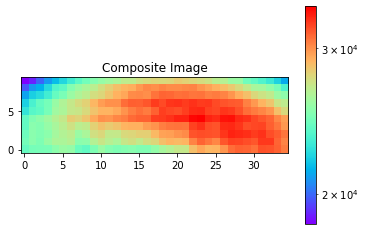

In [2]:
#####################################################################
####################### IMPORT TIME PROFILES ########################
#####################################################################

c = 299792458 # 3E8 / 1.0003

# data parameters
bin_width = 8E-12
t0 = 14.2623e-9; bin0 = round(t0 / bin_width)
numBins = 8192 - bin0
t = np.linspace(0, bin_width * (numBins-1), numBins)

# plot parameters
plotImgs = False

# detector parameters
num_u = 35; num_v = 10 # dimension of video
det_locs = sio.loadmat('../../data/multiplexed_twobounce_021322/results.mat')['x_p']
det_locs = np.flip(np.reshape(det_locs, (num_v, num_u, 3)), axis=1)
# det_locs = np.reshape(det_locs, (num_v, num_u, 3))
nc = np.array([0, 0, 1])

# laser parameters
numSpots_x = 10; numSpots_y = 5
lass = np.transpose(sio.loadmat('../../data/multiplexed_twobounce_021322/results.mat')['D'])
baseline = np.array([0.257, 0, 0])
las_locs = np.zeros((numSpots_y, numSpots_x, 3))
for i in range(numSpots_y):
    if i%2==0:
        las_locs[i, :, :] = np.flip(lass[i*numSpots_x:(1+i)*numSpots_x, :], axis=0)
    else: 
        las_locs[i, :, :] = lass[i*numSpots_x:(1+i)*numSpots_x, :]
# las_locs = np.reshape(las_locs, (numSpots_y, numSpots_x, 3))

# import reference pulse
filename = '../../data/Bounce Flash/replica.mat'
pulseShape = np.squeeze(sio.loadmat(filename)['replica'])[bin0:]
pulseShape = np.roll(pulseShape, 50-np.argmax(pulseShape))
pulseShape = pulseShape / np.max(pulseShape)

# import histograms and visibility matrix
indiv_hists = np.zeros((numSpots_y, numSpots_x, num_v, num_u, numBins)) 
observation = np.zeros((num_v, num_u, numBins))
vis_gt = np.zeros((numSpots_y, numSpots_x, num_v, num_u))
i = 0
for y in range(numSpots_y):
    for x in range(numSpots_x):
        num = str(i+1)
#         filename = '../../data/multiplexed_twobounce_021322/no_shadow_spot_' + num + '.mat' 
        filename = '../../data/multiplexed_twobounce_021322/shadow_spot_' + num + '.mat'
        dataCube = mat73.loadmat(filename)['dataCube']
        dataCube_r = np.reshape(dataCube[:, bin0:], (num_v, num_u, numBins))
        dataCube_r = np.flip(dataCube_r, axis=1)
        t_int = np.max(dataCube_r, 2)
        
        if (y+1) % 2 == 0:
            x_idx = x
        else: 
            x_idx = numSpots_x - x - 1
        
        # store data
        indiv_hists[y, x_idx, :, :, :] = dataCube_r
        observation += dataCube_r
        vis_gt[y, x_idx, :, :] = t_int

        # plot time-integrated images
        if plotImgs:
            plt.figure(); plt.title('y = ' + str(y+1) + ', x = ' + str(x_idx+1))
            im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
            plt.colorbar(im)
        i += 1
        
# # indiv_hists2 = lowPassFilter(t, indiv_hists, bin_width, 0.7E10, False)
# observations = np.sum(indiv_hists, axis=1)

# plot superimposed image
plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(observation, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)
plt.show()

# Generate and Plot Basis Vectors

/var/folders/4p/0q_dfsrd3x13x_xh9k0_vc2r0000gn/T/ipykernel_5747/3026936654.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure();


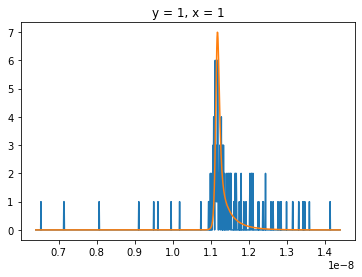

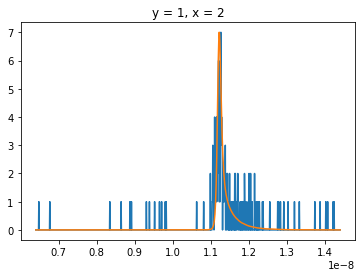

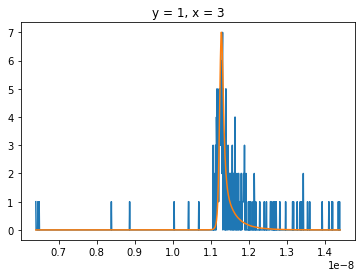

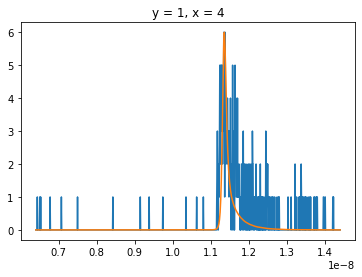

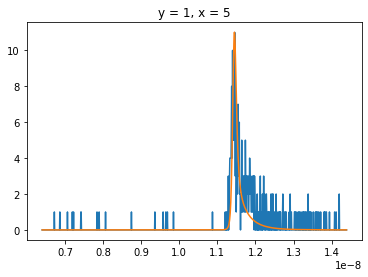

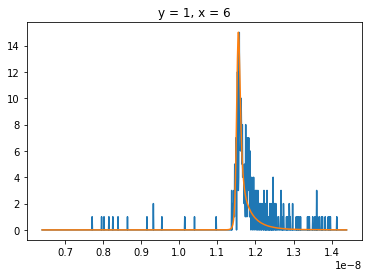

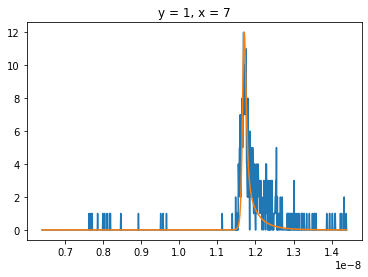

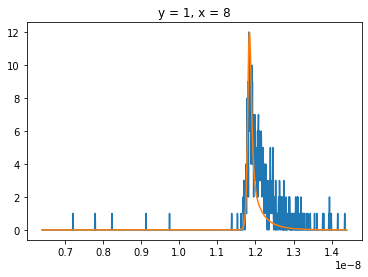

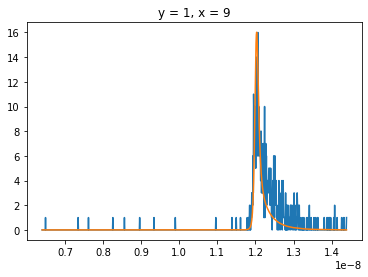

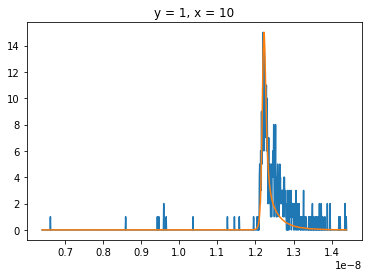

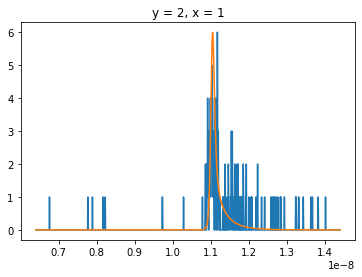

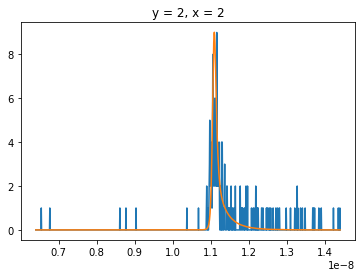

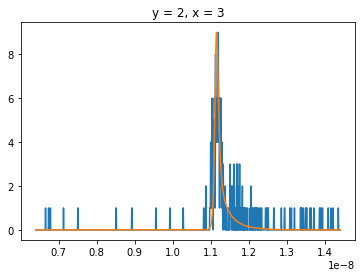

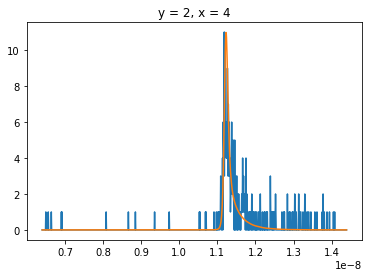

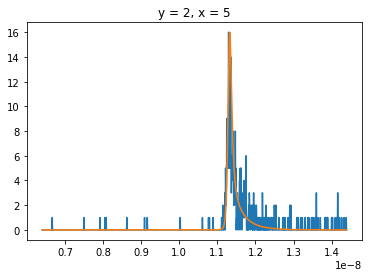

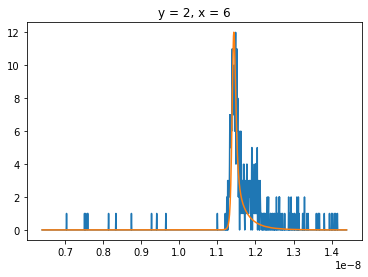

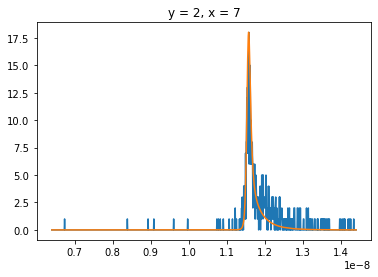

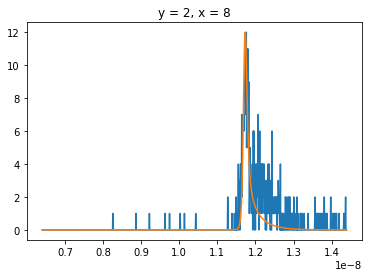

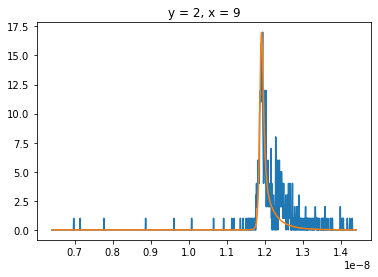

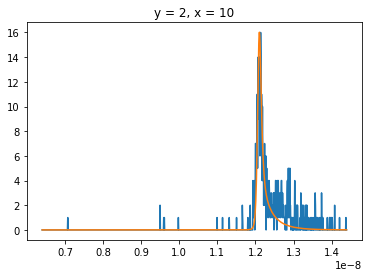

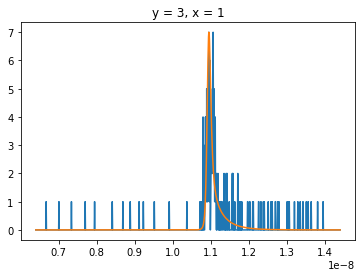

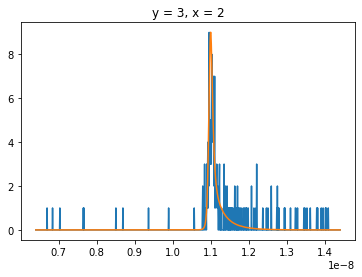

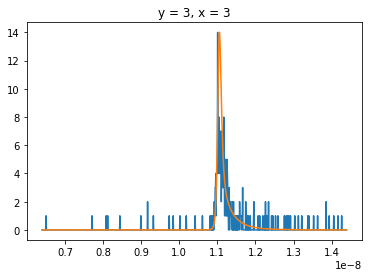

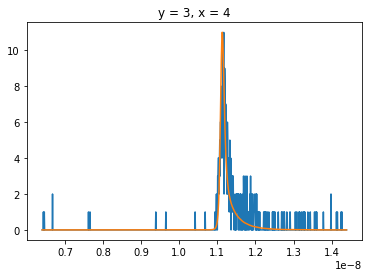

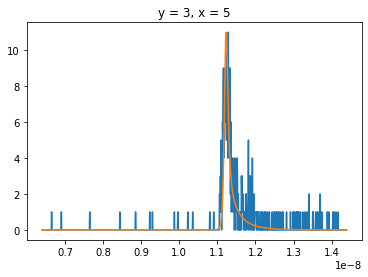

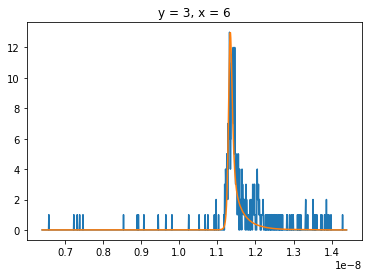

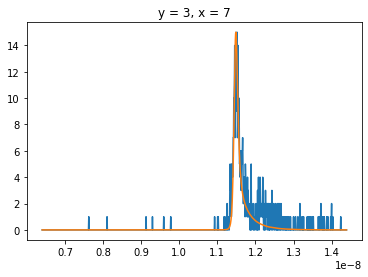

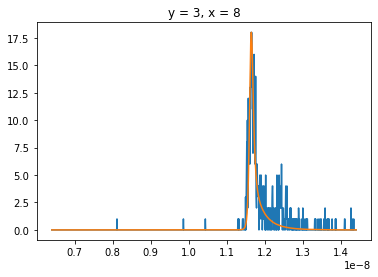

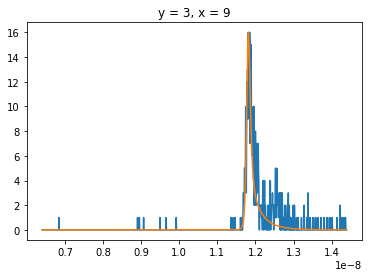

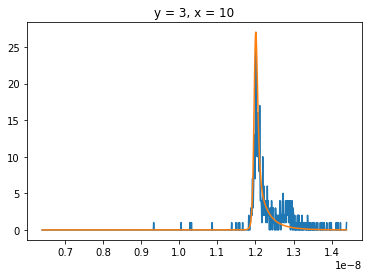

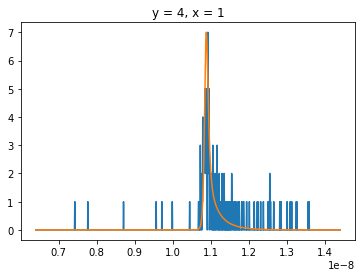

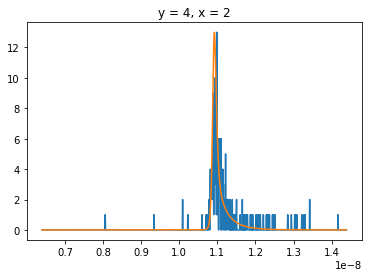

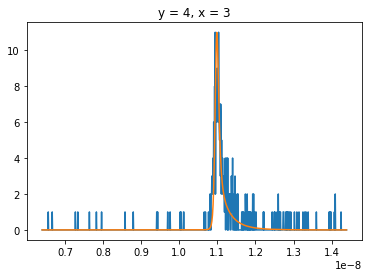

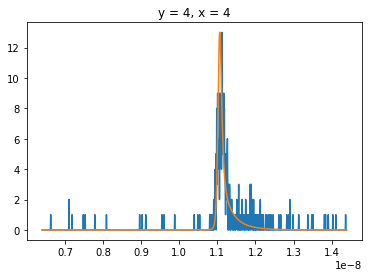

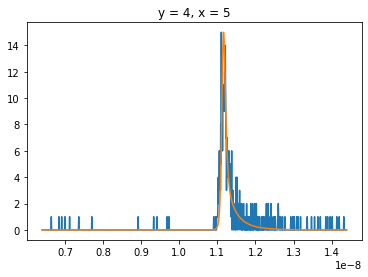

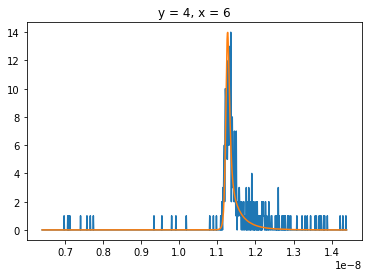

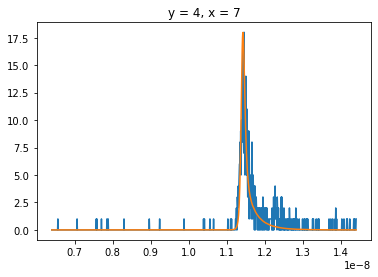

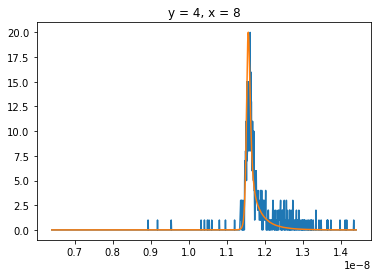

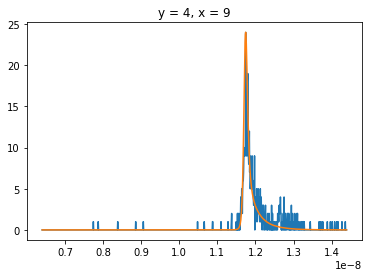

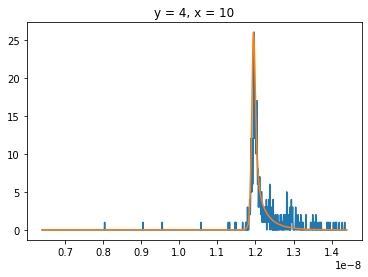

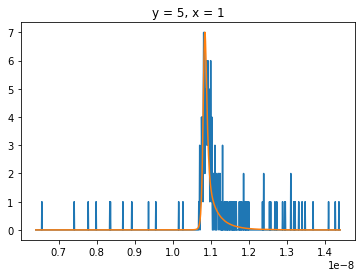

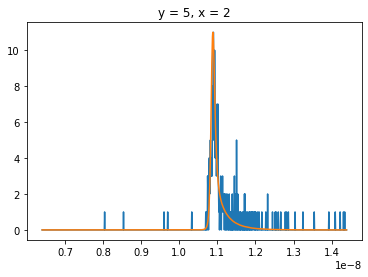

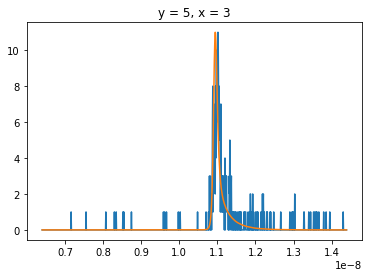

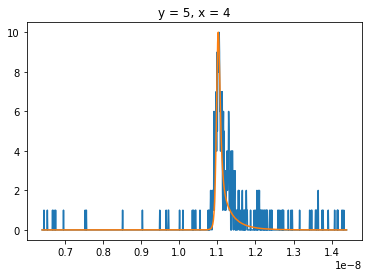

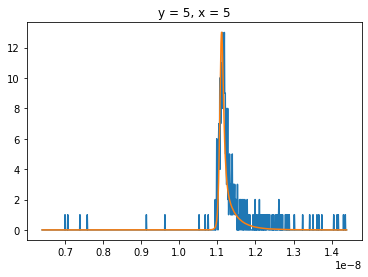

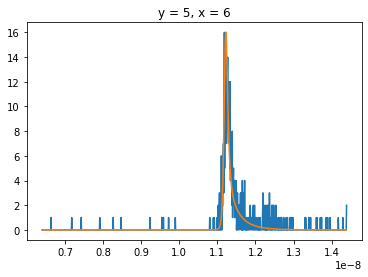

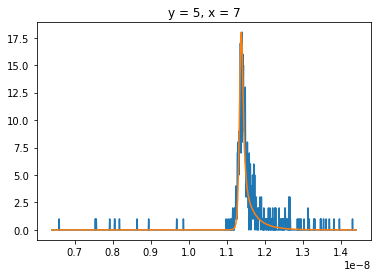

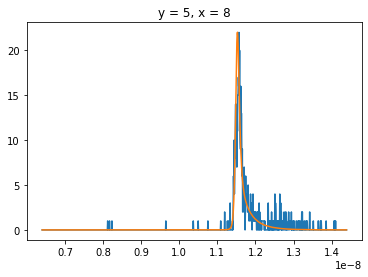

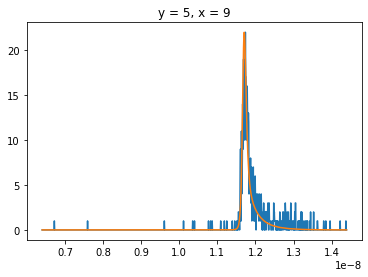

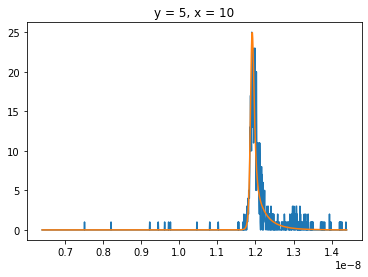

In [3]:
tofs, basisHists = generateBasisFunction(las_locs, det_locs, t, baseline, pulseShape, bin_width, c)

testy = 9; testx = 30
i1 = 800; i2 = 1800
for y in range(numSpots_y):
    for x in range(numSpots_x):
        a = indiv_hists[y, x, testy, testx, :]
        
        plt.figure(); 
        plt.plot(t[i1:i2], a[i1:i2])
        scale = np.max(a)
        
        b = scale*basisHists[y, x, testy, testx, :]
        plt.plot(t[i1:i2], b[i1:i2])

        plt.title('y = ' + str(y+1) + ', x = ' + str(x+1))

# Compute Visibility Matrix

/var/folders/4p/0q_dfsrd3x13x_xh9k0_vc2r0000gn/T/ipykernel_5747/3885229000.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(); plt.title('y = ' + str(y+1) + ', x = ' + str(x+1))


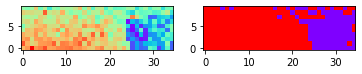

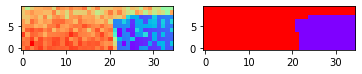

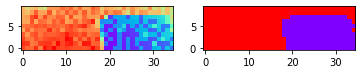

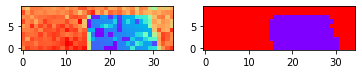

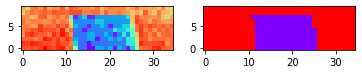

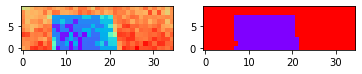

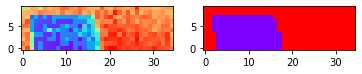

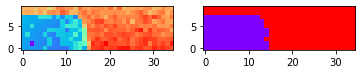

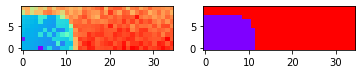

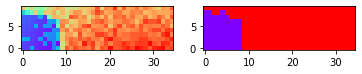

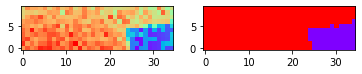

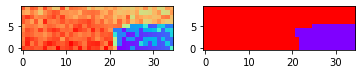

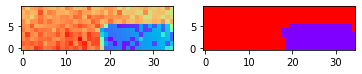

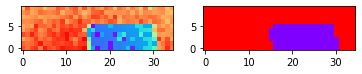

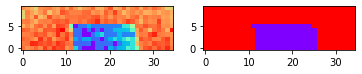

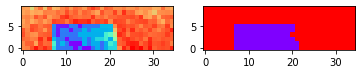

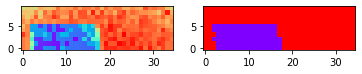

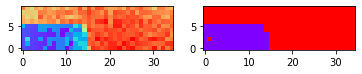

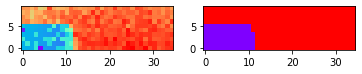

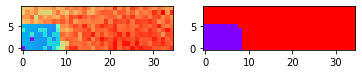

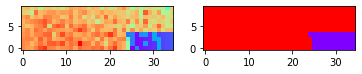

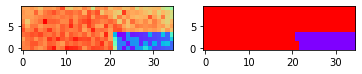

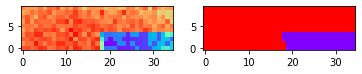

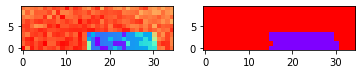

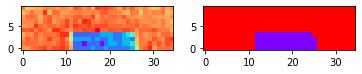

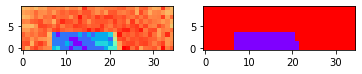

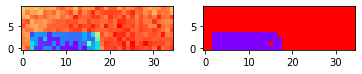

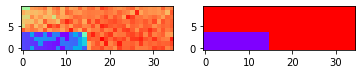

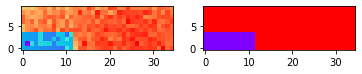

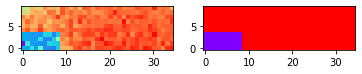

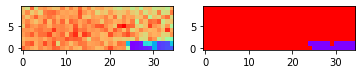

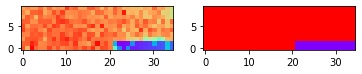

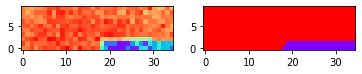

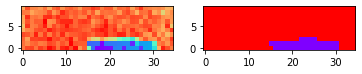

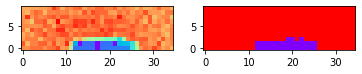

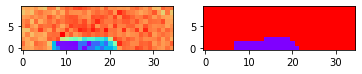

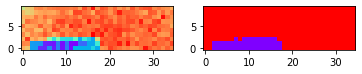

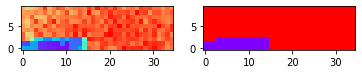

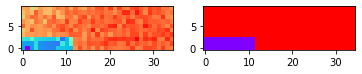

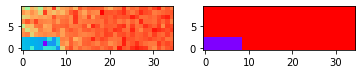

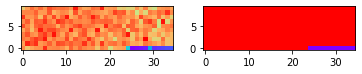

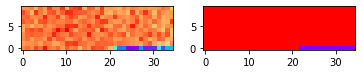

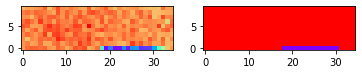

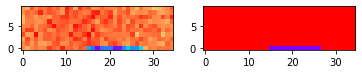

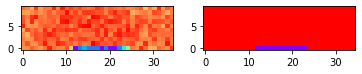

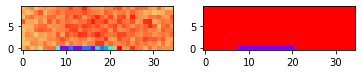

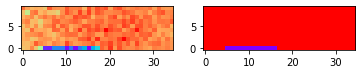

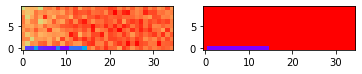

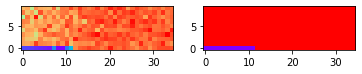

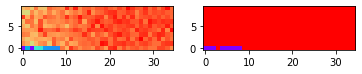

In [4]:
from skimage.filters import threshold_otsu
lit_pts = []; shadow_pts = []; illum_pts = np.zeros((50, 3))
i = 0
vis_gt_bin = np.zeros((numSpots_y, numSpots_x, num_v, num_u))
for y in range(numSpots_y):
    for x in range(numSpots_x):
        r_squared = np.linalg.norm(np.reshape(las_locs[y, x, :], (1, 1, 3)) - det_locs, axis=2)**2
        a = np.copy(vis_gt[y, x, :, :]) * r_squared; #a[0, 0] = 0
        thresh = threshold_otsu(np.log(a))
        binary = (np.log(a) > thresh).astype(int)
#         a[0, 1] = 0; 
        
        # plot images
        plt.figure(); plt.title('y = ' + str(y+1) + ', x = ' + str(x+1))
        plt.subplot(1, 2, 1);
        im = plt.imshow(a, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
        plt.subplot(1, 2, 2);
        im = plt.imshow(binary, cmap=cm.rainbow, origin='lower')

        # store values for space carving
        illum_pts[i, :] = las_locs[y, x, :]
        
        lit_idx = np.nonzero(binary)[0:2]
        inLit = det_locs[lit_idx[0], lit_idx[1], :]
        lit_pts.append(inLit)
        
        shad_idx = np.nonzero(1-binary)[0:2]
        inShadow = det_locs[shad_idx[0], shad_idx[1], :]
        shadow_pts.append(inShadow)        
        
        vis_gt_bin[y, x, :, :] = binary
        i += 1

(240, 3)


Text(0.5, 0.92, 'simple 3D scatter plot')

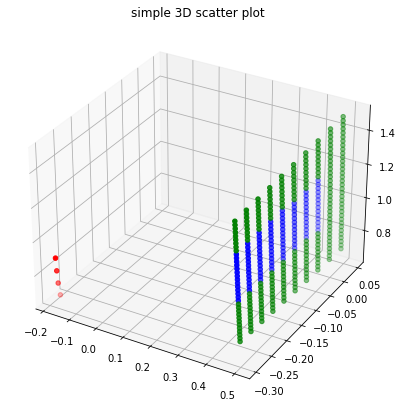

In [5]:
r = 4
light = lit_pts[r] 
print(light.shape)
shade = shadow_pts[r]
source = illum_pts[0:r, :] 

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(source[:, 0], source[:, 1], source[:, 2], color = "red")
ax.scatter3D(light[:, 0], light[:, 1], light[:, 2], color = "green")
ax.scatter3D(shade[:, 0], shade[:, 1], shade[:, 2], color = "blue")
plt.title("simple 3D scatter plot")

In [17]:
print(illum_pts)

[[-0.17309812 -0.28923031  0.66357816]
 [-0.17526963 -0.29247113  0.7398009 ]
 [-0.17573446 -0.29472263  0.81701078]
 [-0.17813353 -0.2949799   0.89226709]
 [-0.17933334 -0.29829216  0.96838397]
 [-0.1778929  -0.30037761  1.04257521]
 [-0.18470302 -0.30193772  1.11479275]
 [-0.18263547 -0.30006403  1.18982045]
 [-0.18534656 -0.30455566  1.26133007]
 [-0.18510967 -0.30606452  1.33302388]
 [-0.17201513 -0.22705857  0.66839476]
 [-0.17378015 -0.22972009  0.74437272]
 [-0.17520833 -0.23191883  0.81984996]
 [-0.17773815 -0.23373901  0.89607082]
 [-0.17944271 -0.23635312  0.970401  ]
 [-0.17897333 -0.23891925  1.04462417]
 [-0.18179236 -0.23769934  1.11848325]
 [-0.18411235 -0.23998608  1.19169013]
 [-0.18538241 -0.24481191  1.26142123]
 [-0.18561787 -0.24392511  1.33510821]
 [-0.17173696 -0.16622087  0.67240064]
 [-0.17329042 -0.16908578  0.74836951]
 [-0.17572463 -0.1709514   0.82459364]
 [-0.177101   -0.1718798   0.89946171]
 [-0.18005165 -0.17441732  0.97300226]
 [-0.18034888 -0.17706575

# Plot Detector and Laser Positions

[ 0.48917808 -0.29356037  0.73883612]
[-0.18510967 -0.30606452  1.33302388]


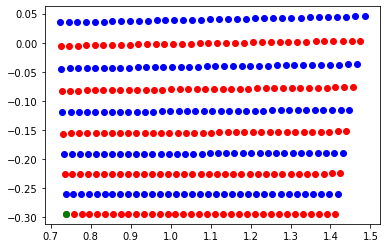

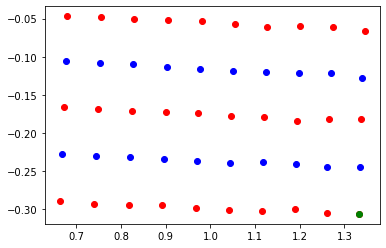

In [7]:
# detector order is reversed (farthest z to closest x) 
# laser order is scan along x, then move up along y in continuous motion (same for detector)

plt.figure()
for i in range(num_v):
    if i%2== 0:
        plt.plot(det_locs[i, :, 2], det_locs[i, :, 1], 'or')
    else:
        plt.plot(det_locs[i, :, 2], det_locs[i, :, 1], 'ob')
y = 0; x = 0
print(det_locs[y, x, :])
plt.plot(det_locs[y, x, 2], det_locs[y, x, 1], 'og')
    
plt.figure()
for i in range(numSpots_y):
    if i%2== 0:
        plt.plot(las_locs[i, :, 2], las_locs[i, :, 1], 'or')
    else:
        plt.plot(las_locs[i, :, 2], las_locs[i, :, 1], 'ob')
x = -1; y = 0
print(las_locs[y, x, :])
plt.plot(las_locs[y, x, 2], las_locs[y, x, 1], 'og')

# Helper Functions

In [8]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, numSpots_y, numSpots_x, numPixels_y, numPixels_x):
        super().__init__()
        # initialize weights with random numbers
        vis = torch.rand(numSpots_y, numSpots_x, numPixels_y, numPixels_x)
        vis = torch.where(vis > 0.5, 1.0, 0.0)
        
        # make weights torch parameters
        self.vis = nn.Parameter(vis, requires_grad = True)      
        
    def forward(self, hists):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
#         vis = torch.sigmoid(self.vis)
        vis = self.vis
        obs = torch.sum(hists * vis.unsqueeze(-1), axis=(0, 1))
        return obs

def training_loop(model, histograms, observations, optimizer, thresh, lam, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        preds = model(histograms)
        loss1 = F.mse_loss(preds, observations) 
        loss2 = torch.sum(torch.square(torch.diff(model.vis, n=1, axis=0))) + torch.sum(torch.square(torch.diff(model.vis, n=1, axis=1))) 
        + torch.sum(torch.square(torch.diff(model.vis, n=1, axis=2))) + torch.sum(torch.square(torch.diff(model.vis, n=1, axis=3))) 
        loss = loss1 + lam * loss2
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
        if i % 1 == 0:
            print(str(i) + " iterations complete")
    return losses

# Time Domain Optimization

(10, 35, 6409)


/var/folders/4p/0q_dfsrd3x13x_xh9k0_vc2r0000gn/T/ipykernel_5747/2649788250.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 5))


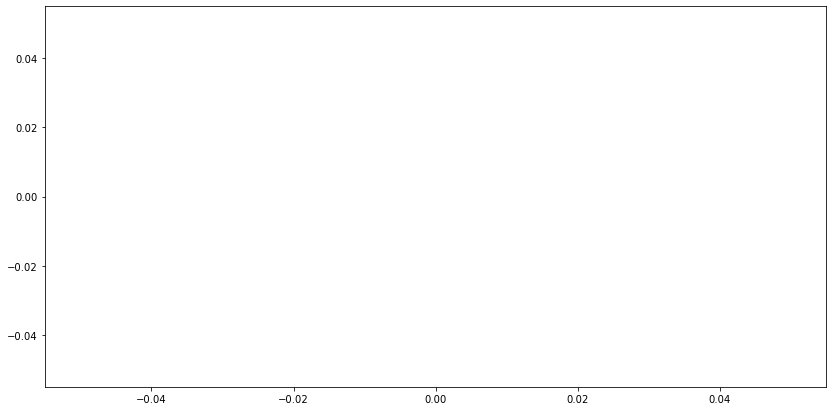

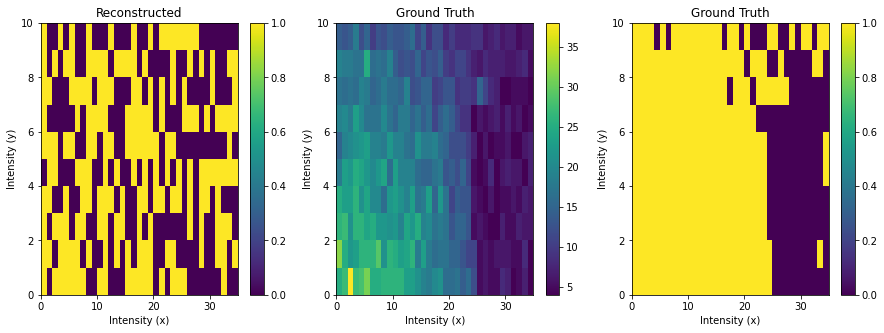

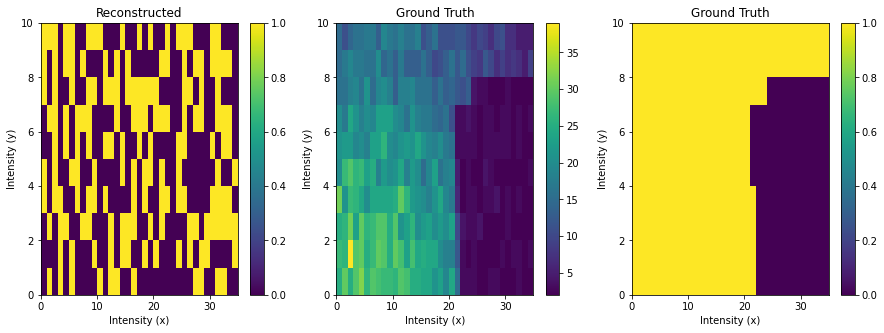

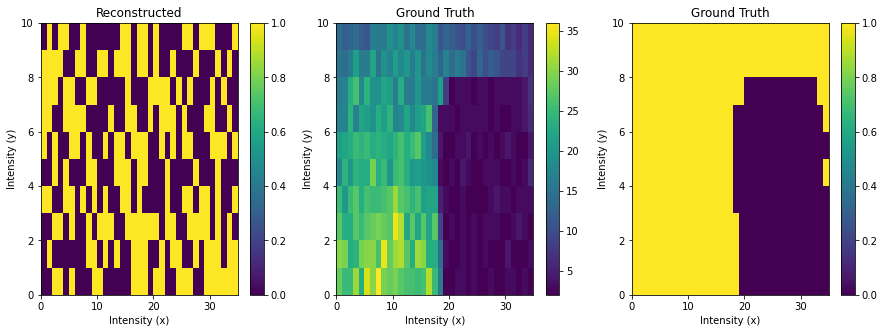

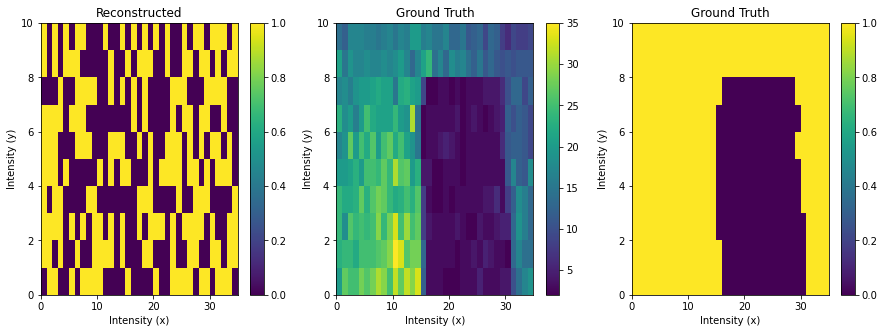

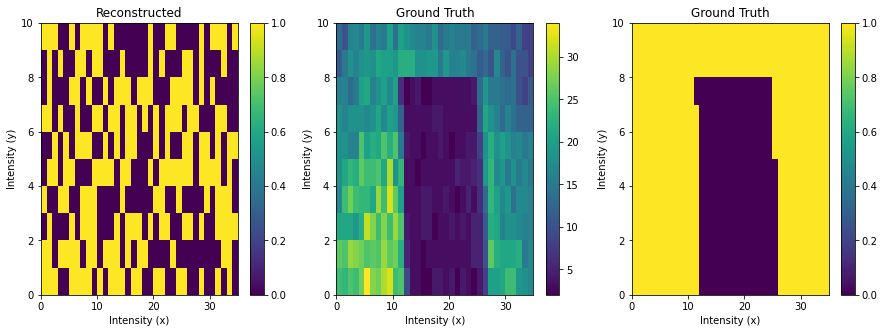

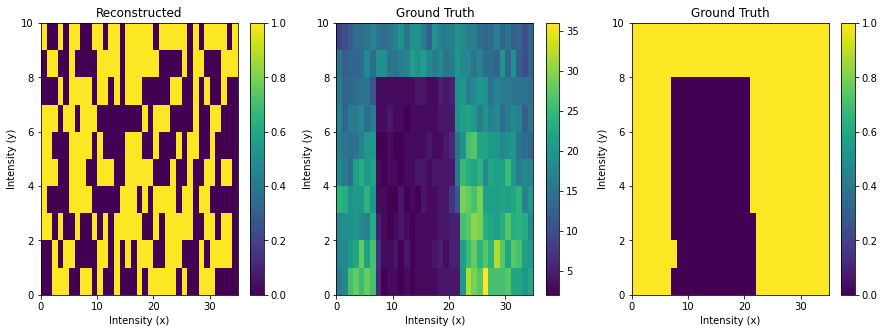

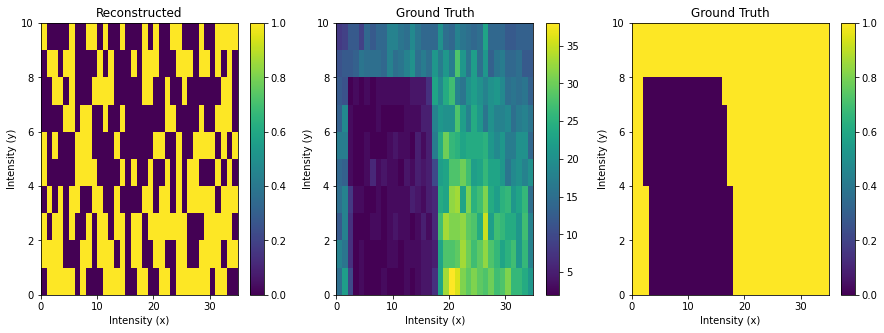

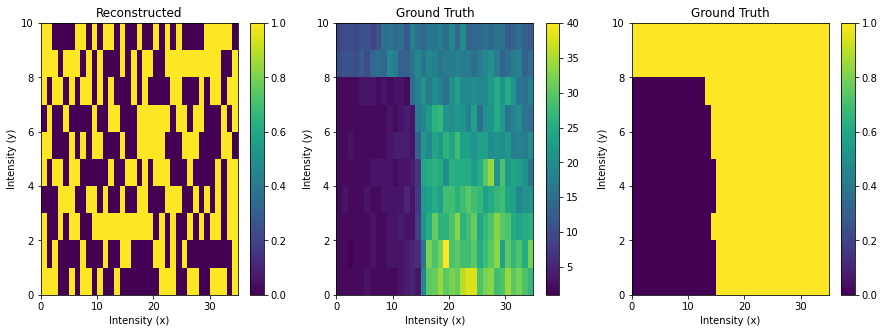

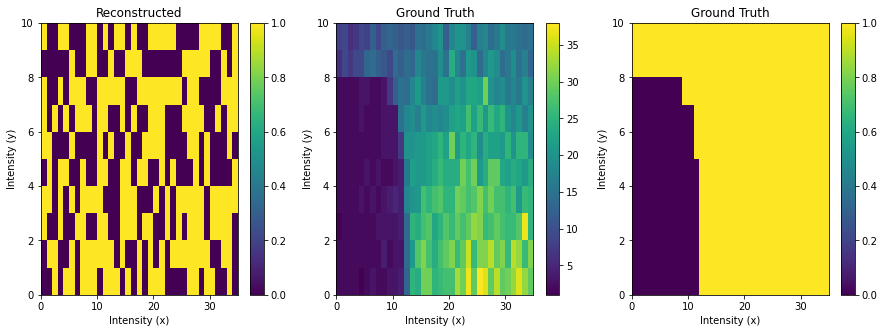

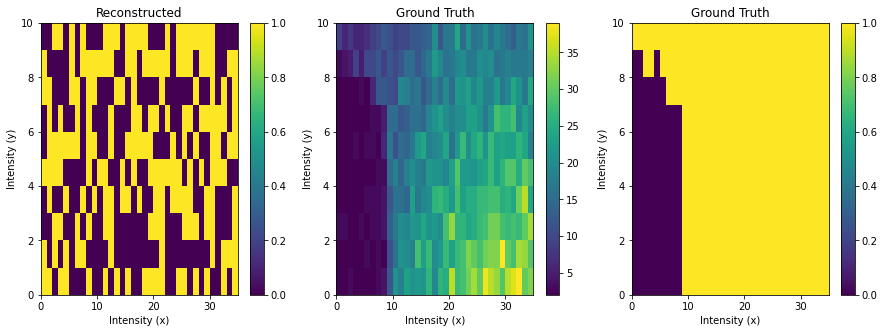

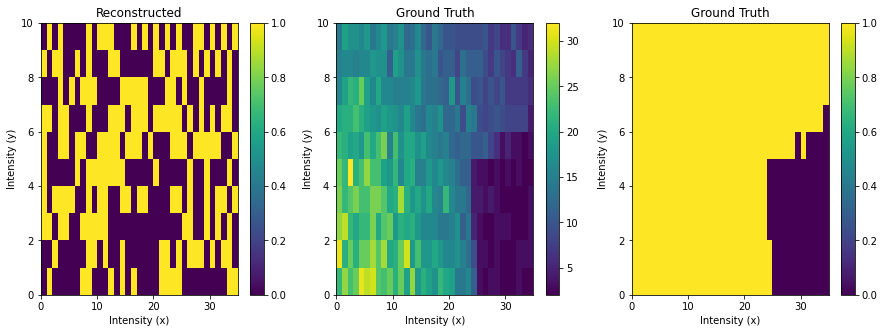

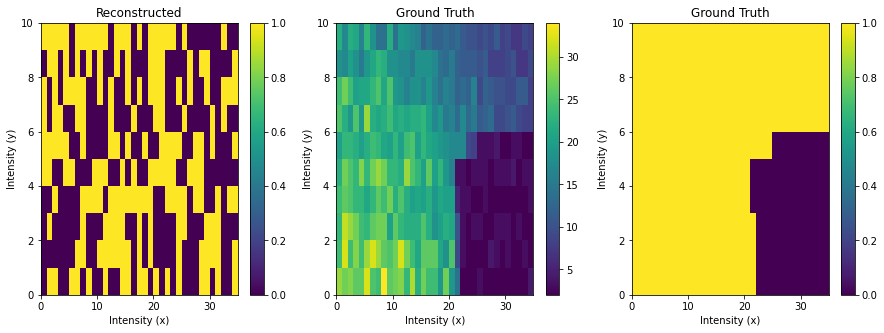

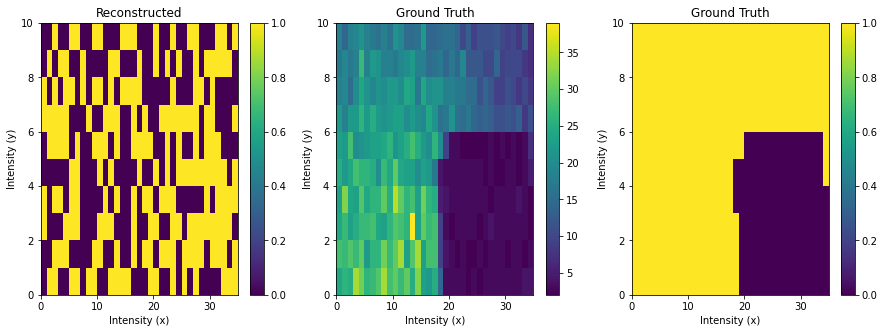

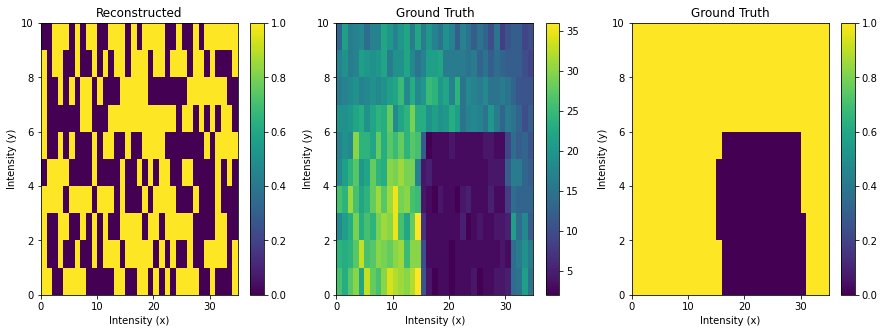

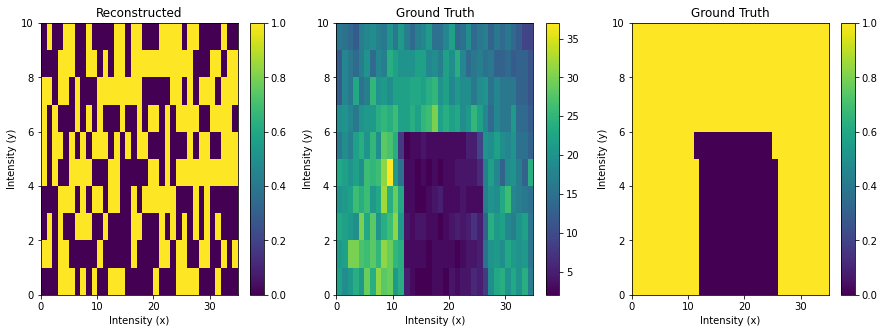

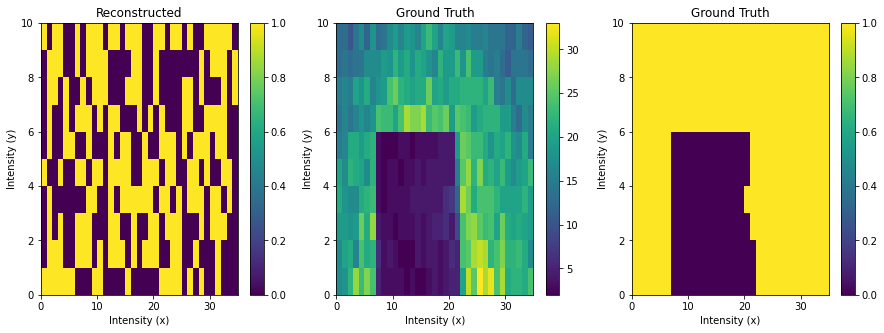

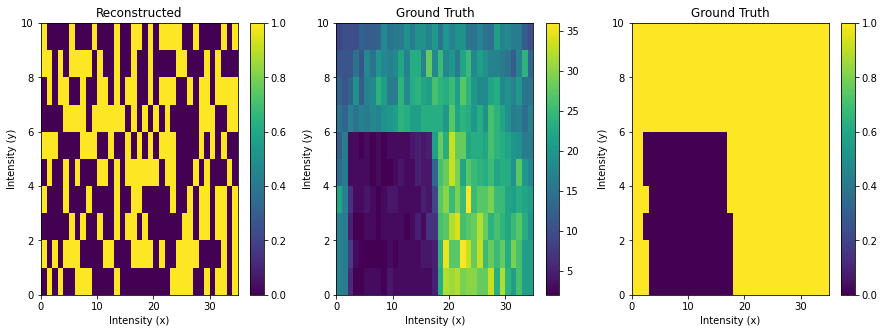

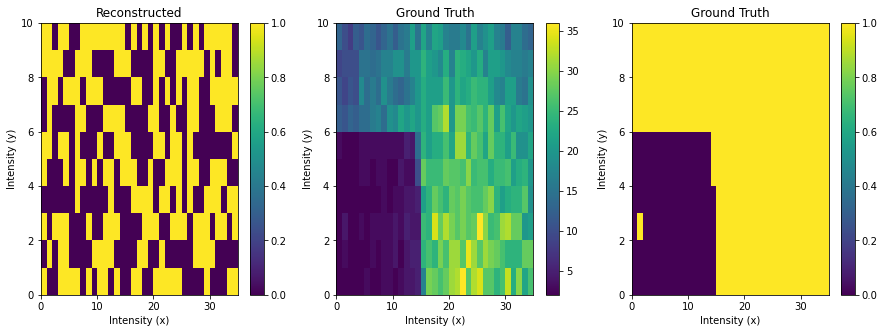

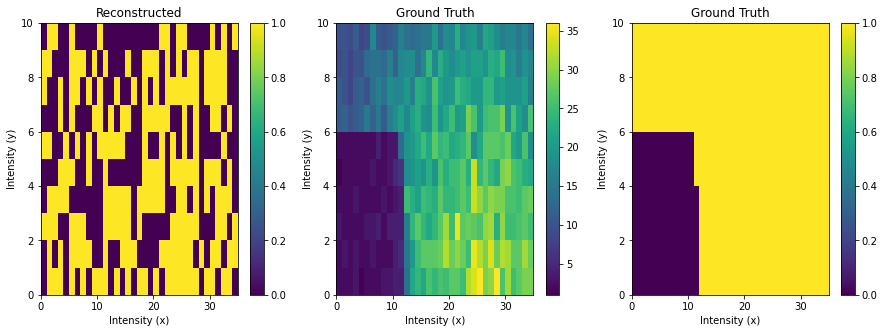

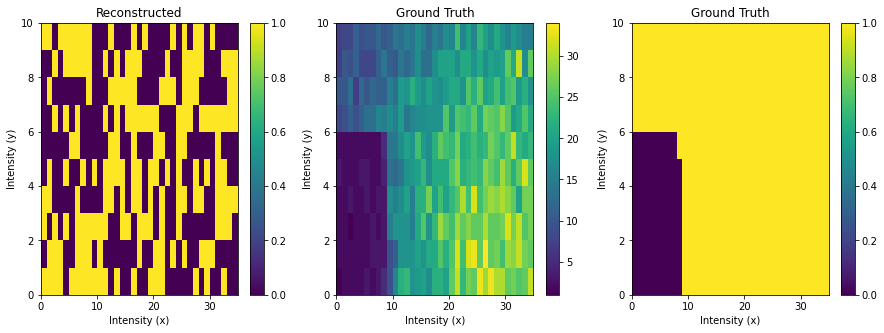

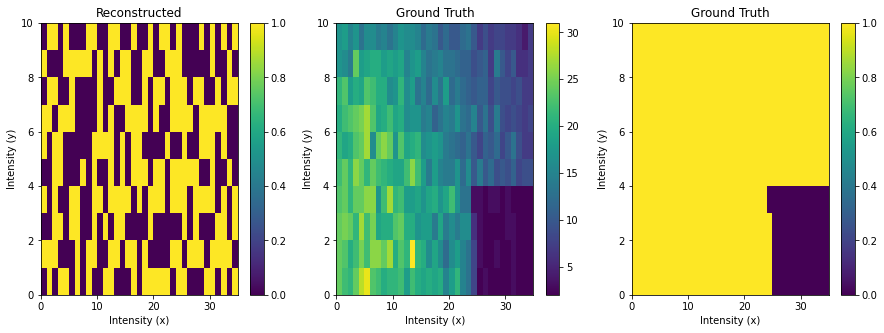

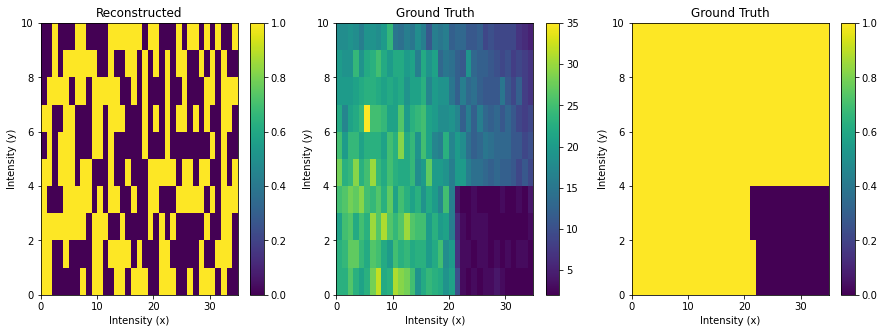

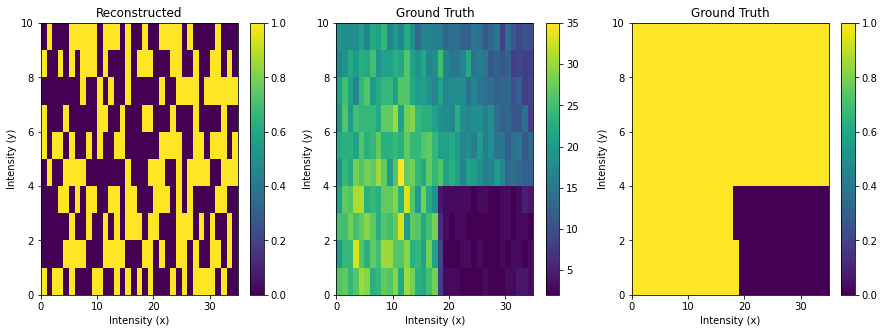

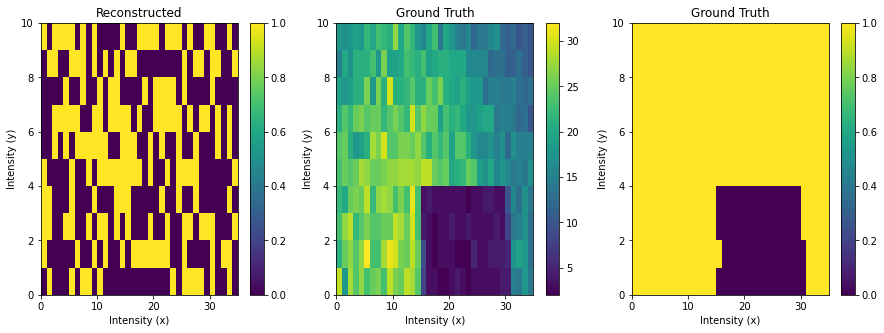

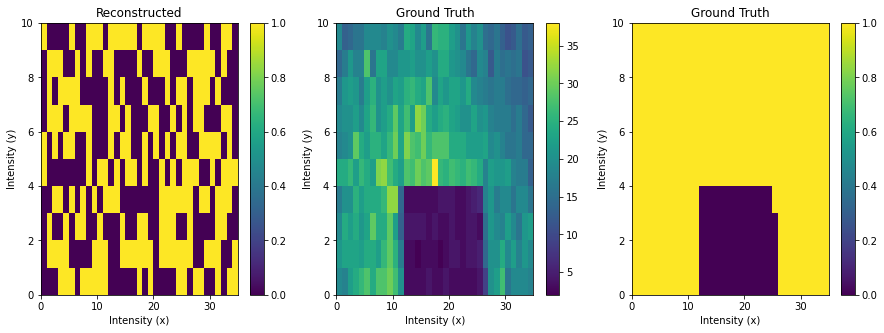

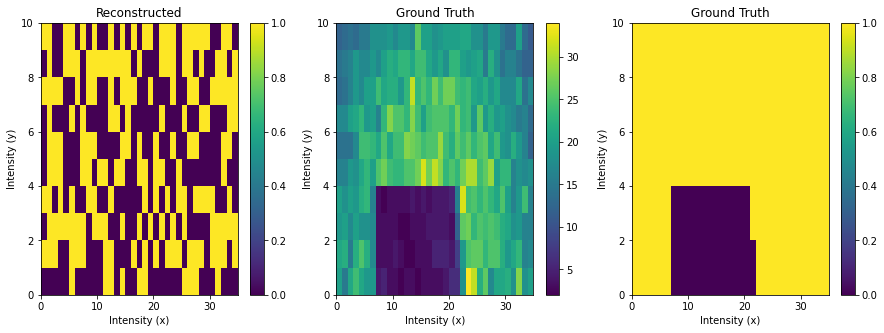

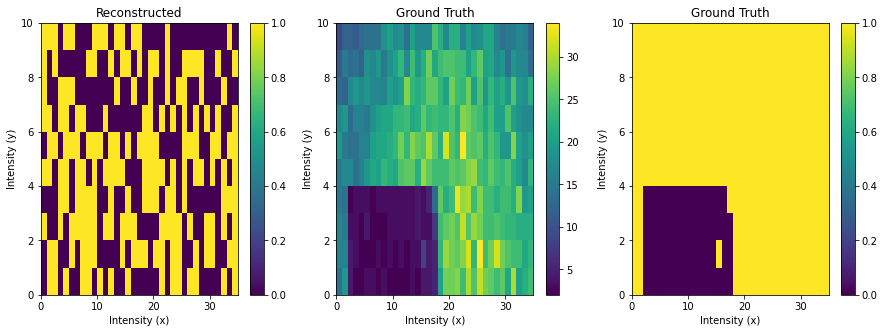

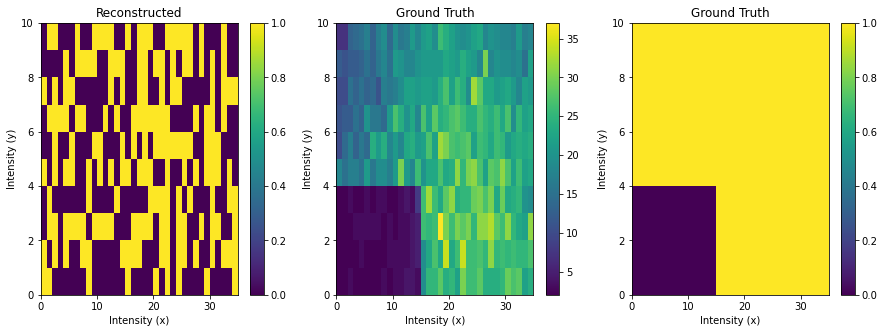

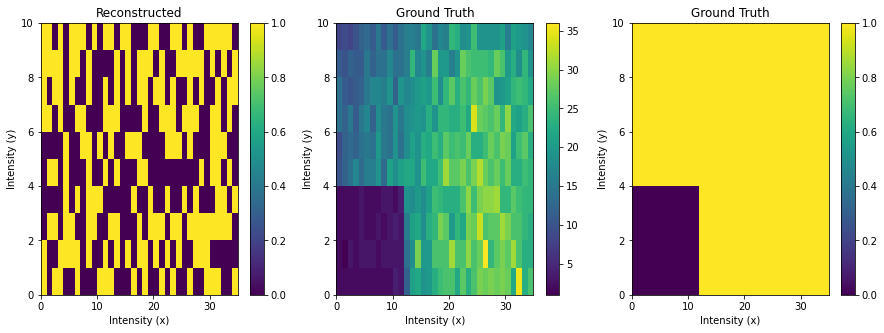

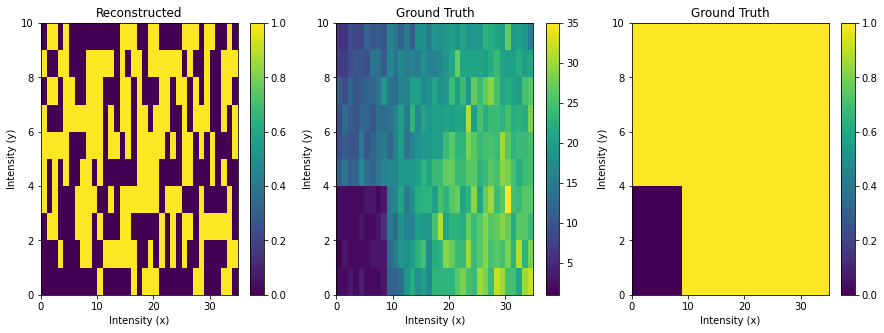

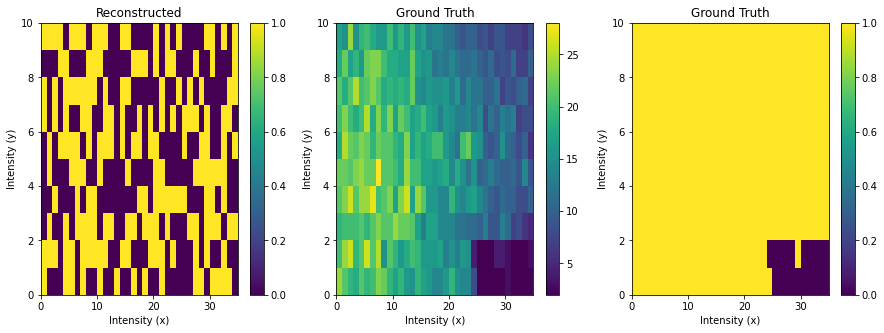

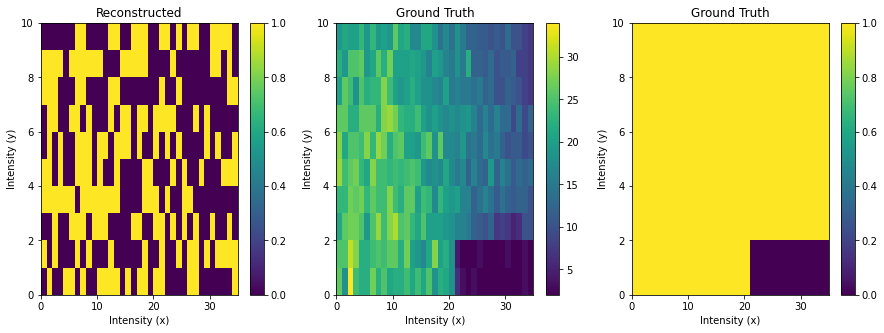

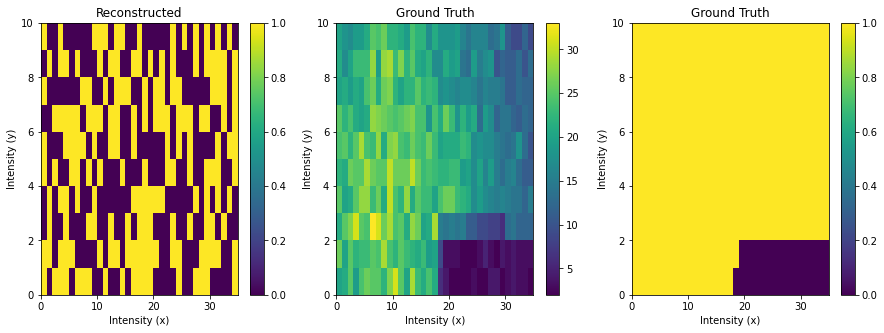

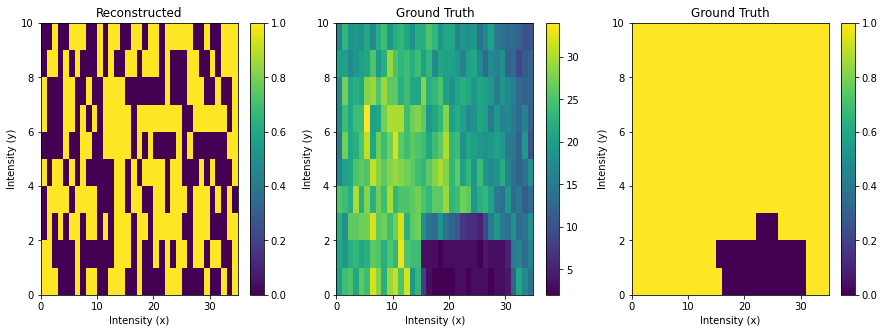

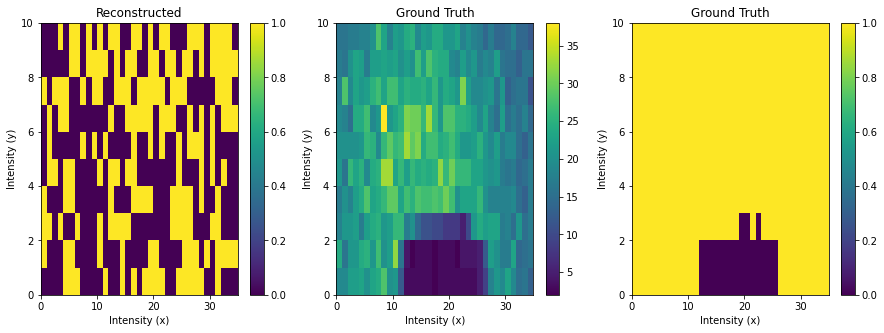

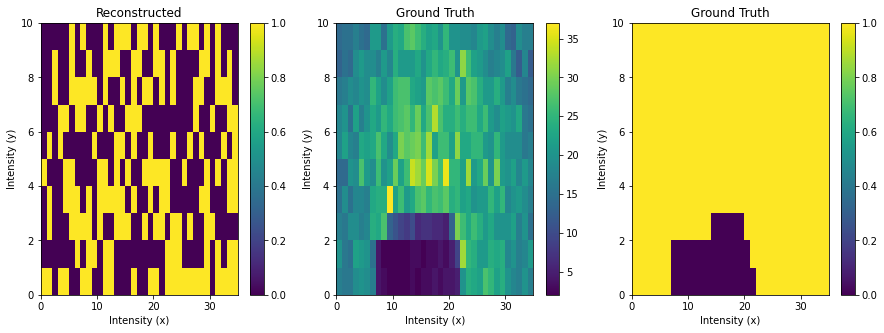

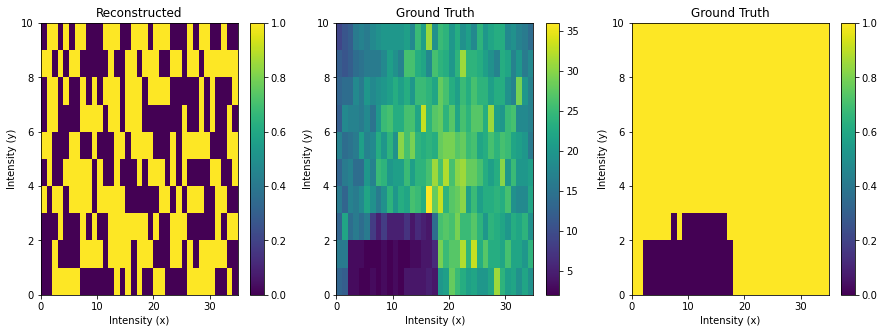

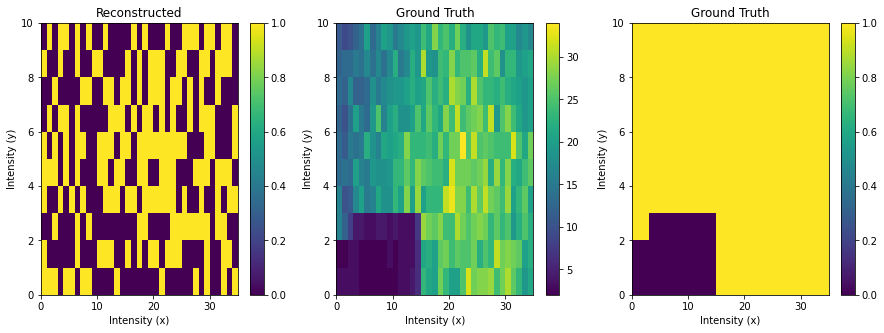

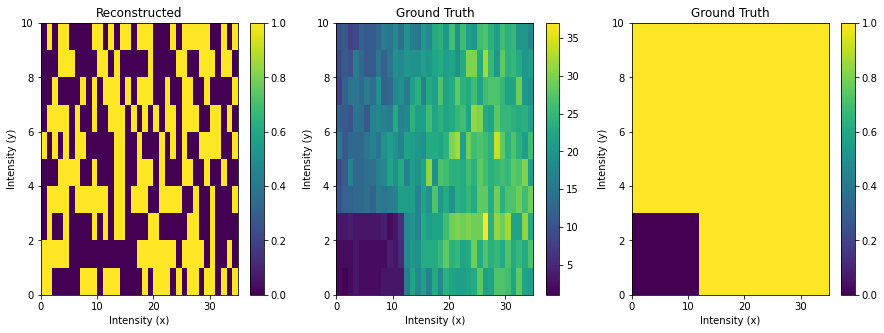

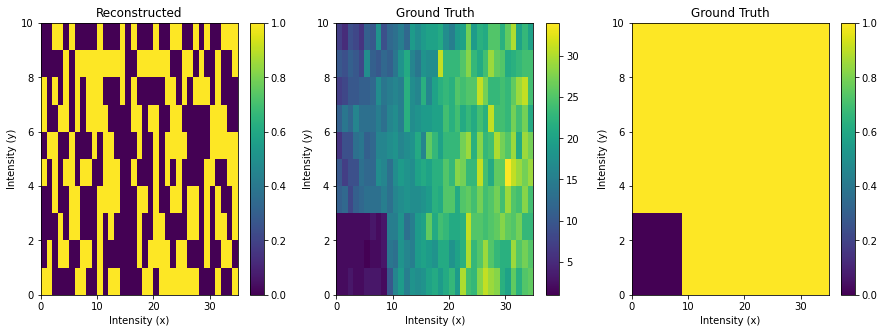

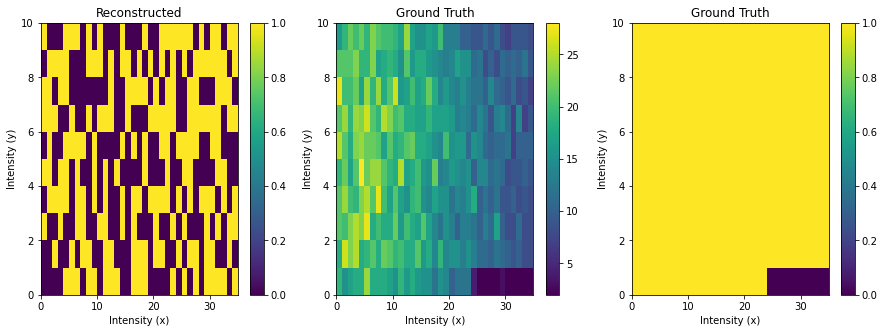

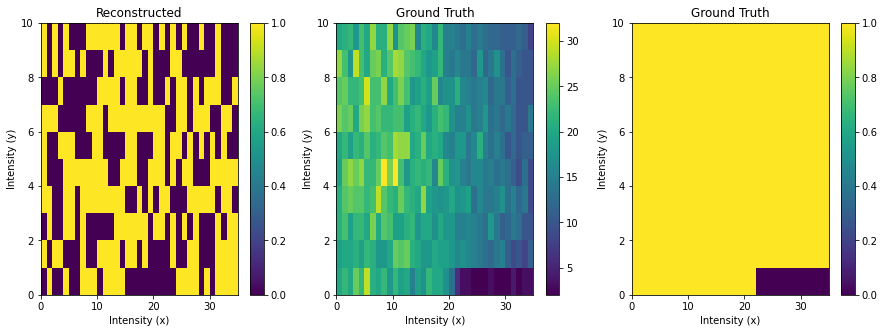

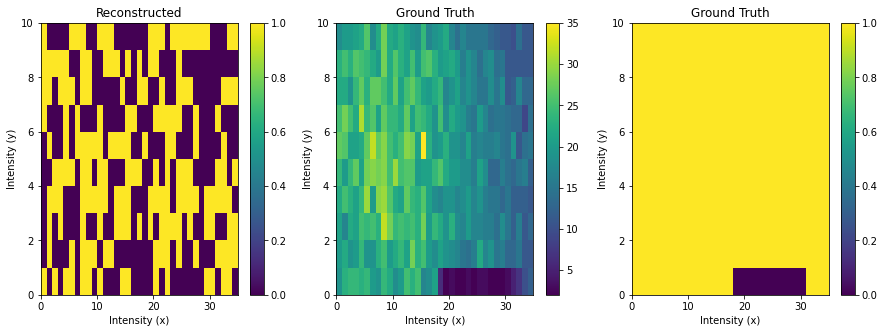

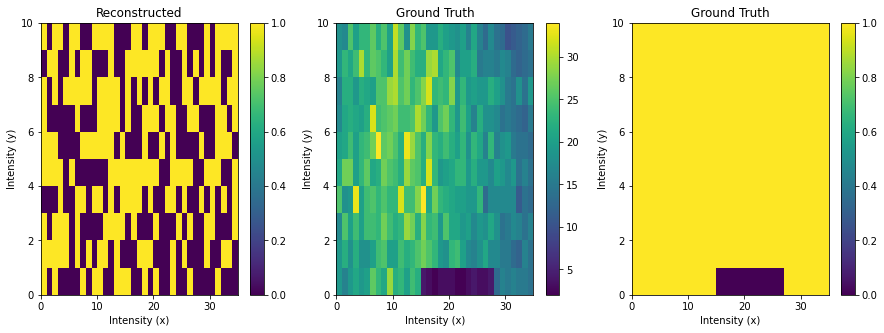

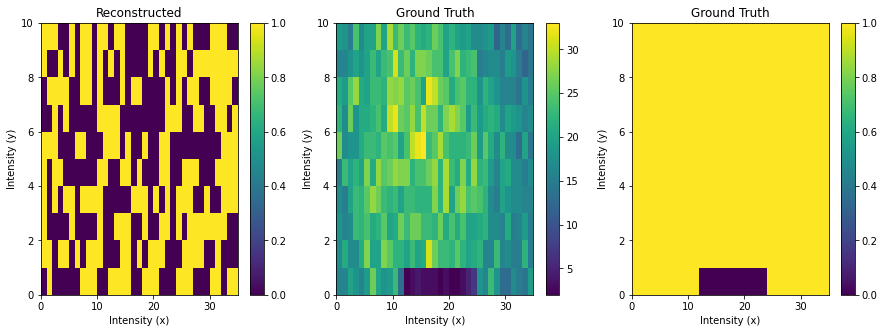

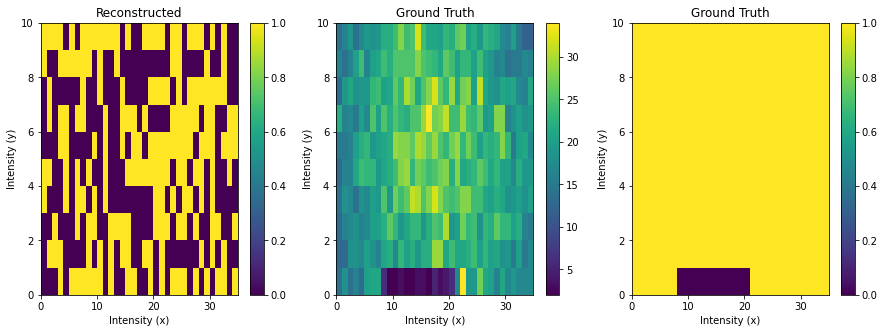

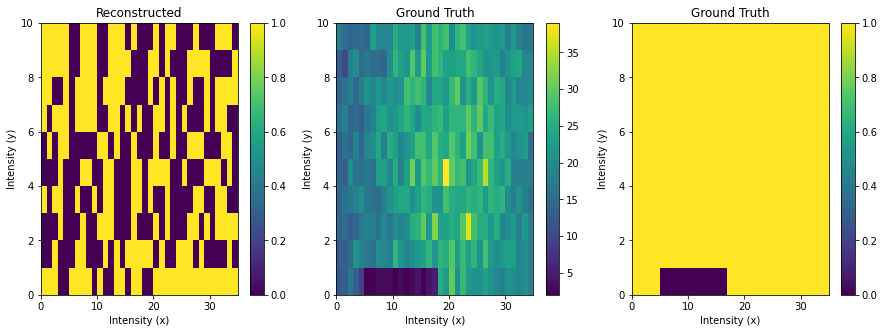

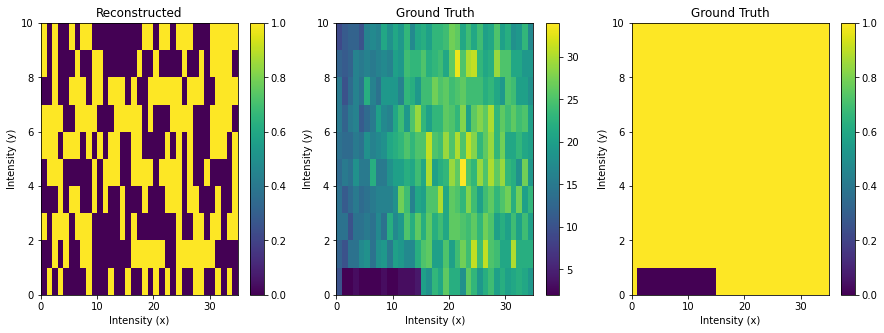

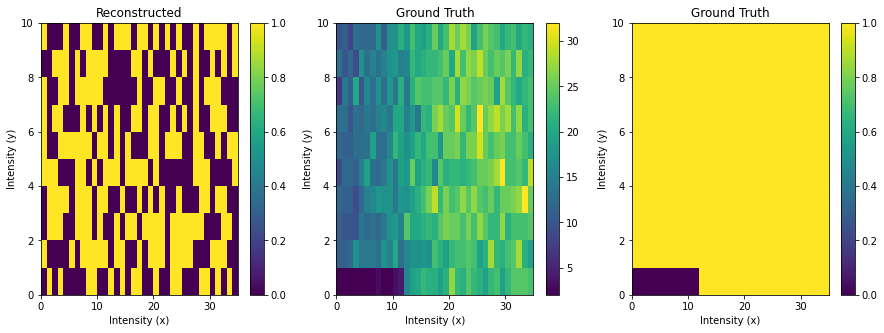

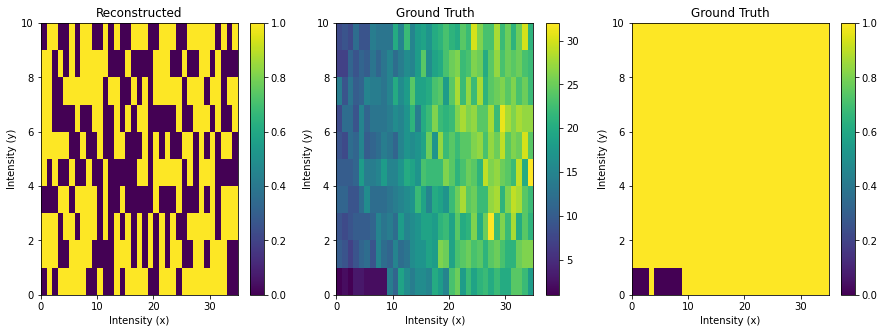

In [9]:
#####################################################################
####### SOLVE INVERSE PROBLEM (RECONSTRUCT VISIBILITY MATRIX) #######
#####################################################################

obs = np.sum(indiv_hists, axis=(0, 1))
print(obs.shape)

c = 299792458 # 3E8 / 1.0003

# optimization parameters
numIters = 0 # 100
thresh = 1E-100
lr_rate = 0.1
lam = 1E-5 # 5E2 for noiseless case

# plotting parameters
plotError = True

# gradient descent
m = Model(numSpots_y, numSpots_x, num_v, num_u)
opt = torch.optim.Adam(m.parameters(), lr=lr_rate)

obs_filt = torch.tensor(obs)
hists_norm = torch.tensor(basisHists)

losses = training_loop(m, hists_norm, obs_filt, opt, thresh, lam, n=numIters)
vis = m.vis.detach()
# vis = torch.sigmoid(vis)
v_reconst = vis
# v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
# v_reconst = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

# plot optimization loss
if plotError:
    plt.figure(figsize=(14, 7))
    plt.plot(losses)

for y in range(numSpots_y):
    for x in range(numSpots_x):
        # plot visibility matrix
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Reconstructed')
        plt.pcolormesh(v_reconst[y, x, :, :]); plt.colorbar()
        plt.xlabel('Intensity (x)'); plt.ylabel('Intensity (y)')
        # plt.title('t0 = ' + str(t0))

        plt.subplot(1, 3, 2)
        plt.title('Ground Truth')
        plt.pcolormesh(vis_gt[y, x, :, :]); plt.colorbar()
        plt.xlabel('Intensity (x)'); plt.ylabel('Intensity (y)')
        
        plt.subplot(1, 3, 3)
        plt.title('Ground Truth')
        plt.pcolormesh(vis_gt_bin[y, x, :, :]); plt.colorbar()
        plt.xlabel('Intensity (x)'); plt.ylabel('Intensity (y)')

# compare ground truth visibility matrix
# error = np.sum(np.abs(v_reconst-vis_gt))
# pct_error = 100 * error / (numSpots_y * numPixels_z * numPixels_y)
# print(str(error) + ' / ' + str(numPixels_z * numPixels_y * numSpots_y) + ' entries in visibility matrix misclassified')
# print(str(pct_error) + '% of entries in visibility matrix misclassified')

# onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
# print(str(onesToZero) + ' ones flipped to zeros')
# print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
# end = timer()
# print(end - start)

# Space Carving

In [23]:
# IMPLEMENT BOUNCE_FLASH_ROBUST_CARVING_SCRIPT
class voxelGrid():
    def __init__(self, x_lims, y_lims, z_lims, num_x, num_y, num_z):
        self.x_lims = x_lims
        self.y_lims = y_lims
        self.z_lims = z_lims
        self.num_x = num_x
        self.num_y = num_y
        self.num_z = num_z
        self.volume = np.zeros((num_x, num_y, num_z))

# discretize hidden space
x_lims = np.array([-0.13, 0.4])
y_lims = np.array([-0.3, -0.05])
z_lims = np.array([0.8, 1.3])
num_x = 20
num_y = 20
num_z = 20
outside_voxel = voxelGrid(x_lims, y_lims, z_lims, num_x, num_y, num_z)
inside_voxel = voxelGrid(x_lims, y_lims, z_lims, num_x, num_y, num_z)

# count number of times lit and shadow pixel intersects voxel
print("Commence Robust Carving")
for i in range(len(lit_pts)):
    # lit_pts = 17 x 1 list (contains pixels not in shadow for each light source)
    # shadow_pts = 17 x 1 list (contains pixels in shadow for each light source)
    # illum_pts = 17 x 3 double (contains locations of light sources)
    outside_voxel, inside_voxel = robust_carving_frame(outside_voxel, inside_voxel, illum_pts[i, :], 
                                                         lit_pts[i], shadow_pts[i])
    print(i)

Commence Robust Carving
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [ ]:
# probabilistic space carving
eta = .05 # Probability occupied voxel is traced to illuminated region (miss probability) --> higher = undervarve
xi = 0.5 # Probability that an empty voxel is traced to shadow (probability false alarm) --> higher = overcarve
p0 = 0.8 # Prior probability that any voxel is empty
p1 = 0.2 # Prior probability that any voxel is occupied
T = 0.8 # Probability threshold to decide that voxel is occupied

m = np.linspace(0, len(lit_pts), len(lit_pts)+1) 
n = np.linspace(0, len(lit_pts), len(lit_pts)+1) 
[M, N] = np.meshgrid(m, n)
PO = p1 * (eta**M) * ((1-eta)**N)/(p0*((1-xi)**M)*(xi**N) + p1*(eta**M)*((1-eta)**N))

# visualize 3D reconstruction
testDets = np.zeros((num_u*num_v, 3))
testLas = np.zeros((numSpots_x*numSpots_y, 3))
i = 0
for x in range(num_u):
    for y in range(num_v):
        testDets[i, :] = det_locs[y, x, :]
        i += 1
i = 0
for x in range(numSpots_x):
    for y in range(numSpots_y):
        testLas[i, :] = las_locs[y, x, :]
        i += 1
volume, probability_volume = visualize_probablistic(inside_voxel, outside_voxel, PO, T, testLas, testDets, True)

# Plotting Code

(-0.5, 34.5, -0.5, 9.5)

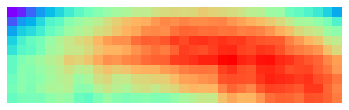

In [12]:
t_int = np.sum(observation, 2)
plt.figure(); #plt.title('y = ' + str(y+1) + ', x = ' + str(x_idx+1))
im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.axis('off')
# plt.savefig('composite.png')
# plt.colorbar(im)

In [13]:
if False:
    xShape = np.linspace(-0.13, 0.4)
    yShape = np.linspace(-0.3, -0.05)
    zShape = np.linspace(0.8, 1.3)
    X, Y, Z = np.meshgrid(xShape, yShape, zShape)
    testShape = np.stack((np.ndarray.flatten(X), np.ndarray.flatten(Y), np.ndarray.flatten(Z)), axis=0)
    testShape = np.transpose(testShape)

    testDets = np.zeros((num_u*num_v, 3))
    testLas = np.zeros((numSpots_x*numSpots_y, 3))
    i = 0
    for x in range(num_u):
        for y in range(num_v):
            testDets[i, :] = det_locs[y, x, :]
            i += 1
    i = 0
    for x in range(numSpots_x):
        for y in range(numSpots_y):
            testLas[i, :] = las_locs[y, x, :]
            i += 1
    print(testDets.shape)
    print(testLas.shape)
    print(testShape.shape)
    ptCloud = np.vstack((testDets, testLas, testShape))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ptCloud)
    o3d.io.write_point_cloud("../../data/multiplexed_twobounce_021322/result.ply", pcd)

    # Visualize point cloud (WARNING: This will open another window and you will be forced to kill kernal)
    if True:
        cloud = o3d.io.read_point_cloud("../../data/multiplexed_twobounce_021322/result.ply") # Read the point cloud
        o3d.visualization.draw_geometries([cloud])

# Miscellaneous Functions

In [14]:
def lowPassFilter(t, a, bin_width, w_thresh):
    # a = numDets_y x numDets_x x numBins
    # compute fft
    a_fft = np.fft.fft(a, axis=-1)
    a_fft_shift = np.fft.fftshift(a_fft, axes=-1)
    f = np.fft.fftfreq(len(t), bin_width)
    f_shift = np.reshape(np.fft.fftshift(f, axes=-1), (1, 1, len(t)))
        
    # compute lowpass reconstruction
    fft_filtered = a_fft_shift * (np.abs(f_shift) < w_thresh)
    
    rec_filt = np.real(np.fft.ifft(np.fft.fftshift(fft_filtered, axes=-1), axis=-1))

    return rec_filt

In [15]:
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'same') / w

# i1 = 1300; i2 = 1800 
# # i1 = 0; i2 = -1

# # plot individual histograms
# leg = []
# plt.figure()
# pixelHist = indiv_hists[i, 8, 5, i1:i2]
# observation = np.zeros((num_v, num_u, numBins))
# for i in range(20, 30-8):
#     a = lowPassFilter(t, indiv_hists[i, 8, 5, :], bin_width, 2E10, False)
#     a = moving_average(a, 10)
# #     a = moving_average(indiv_hists[i, 8, 5, :], 1)
#     observation += a
#     plt.plot(t[i1:i2], a[i1:i2])
#     leg.append('spot # ' + str(i+1))

# # plot superimposed histogram
# # observation = np.sum(indiv_hists[20:30, :, :, :] , axis=0)
# print(observation.shape)
# # plt.figure()
# pixelHist = observation[8, 5, :]
# plt.plot(t[i1:i2], pixelHist[i1:i2])
# leg.append('Cumulative Histograms')
# plt.plot(t[i1:i2], np.roll(10 * pulseShape, 1400)[i1:i2])
# leg.append('Reference')
# plt.legend(leg)

# Plot Point Cloud

In [16]:
if False:
    # Save x, y, z data to .ply file if needed
    testDets = np.zeros((num_u*num_v, 3))
    testLas = np.zeros((numSpots_x*numSpots_y, 3))
    i = 0
    for x in range(num_u):
        for y in range(num_v):
            testDets[i, :] = det_locs[y, x, :]
            i += 1
    i = 0
    for x in range(numSpots_x):
        for y in range(numSpots_y):
            testLas[i, :] = las_locs[y, x, :]
            i += 1

    comb_locs = np.vstack((testLas, testDets))
    if False:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(comb_locs)
        o3d.io.write_point_cloud("../../data/multiplexed_twobounce_021322/comb.ply", pcd)

    # Visualize point cloud (WARNING: This will open another window and you will be forced to kill kernal)
    if False:
        cloud = o3d.io.read_point_cloud("../../data/multiplexed_twobounce_021322/comb.ply") # Read the point cloud
        o3d.visualization.draw_geometries([cloud])